<a href="https://colab.research.google.com/github/baut-jc/DDDS-My-Projects/blob/main/Project-5/Project5_02_NLP_Description_for_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture output
#install Wikipedia API
!pip3 install wikipedia-api

In [74]:
import pandas as pd
import numpy as np
import re

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

import wikipediaapi
import ipywidgets as widgets # ipywidgets are used for creating interactive user interface elements in Jupyter Notebooks.
import nltk

nltk.download('punkt_tab')
pd.options.display.max_columns = 100


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


##Data Collection and Sources

In [ ]:
df=pd.read_csv('https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv')

In [ ]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


((42786, 3), None)

In [ ]:
df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [ ]:
df['name'].unique()[:10] # Displaying first 10 for brevity

array(['Digby Morrell', 'Alfred J. Lewy', 'Harpdog Brown',
       'Franz Rottensteiner', 'G-Enka', 'Sam Henderson', 'Aaron LaCrate',
       'Trevor Ferguson', 'Grant Nelson', 'Cathy Caruth'], dtype=object)

## Data Cleaning

In [ ]:
# Making a copy of 'original_column' (name) for potential later use.
df['copied_name'] = df['name'].copy()

In [ ]:
# Create a copy of the DataFrame to store cleaned text, preserving the original.
df_cleaned = df.copy()

In [ ]:
# Select the target person
# target_names = df_cleaned['name'].sample() #random famous person

target_name = "Dave Bautista" # --> just another 'Bautista ;)'
target_index = df_cleaned[df['name'] == target_name].index[0]

In [ ]:
# Define the `clean_text` function to preprocess text strings. --> 2b-Text.Representation
def clean_text(text):
    text = str(text).lower()                            # Convert text to string and lowercase for normalization (2b-Text.Representation.end (1).ipynb)
    text = re.sub(r'\[.*?\]', '', text)                 # Remove text within square brackets (e.g., citations)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)   # Remove URLs
    text = re.sub(r'<.*?>+', '', text)                  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)  # Remove punctuation (general text cleaning, aligns with concepts in 2b-Text.Representation.end (1).ipynb on tokenization)
    text = re.sub(r'\n', '', text)                      # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [ ]:
# Apply the cleaning function to the 'text' column to create 'cleaned_text'.
df_cleaned['Overview'] = df_cleaned['text'].apply(clean_text)

# Natural Language Processing



This project will give you practical experience using Natural Language Processing techniques. This project is in three parts:
- in part 1) you will use a dataset in a CSV file
- in part 2) you will use the Wikipedia API to directly access content
on Wikipedia.
- in part 3) you will make your notebook interactive


## Part 1: Processing DS for NLP

- The CSV file is available at https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is to ...
  1. Pick one person from the list ( the target person ) and output 10 other people who's overview are "closest" to the target person in a Natural Language Processing sense
  1. Also output the sentiment of the overview of the target person



### 1.1 Natural Language Processing

In [12]:
# ----> Bag of Words
# Perform the count transformation
vectorizer = CountVectorizer(stop_words='english')
bow_vec = vectorizer.fit_transform(df_cleaned['Overview'])
bow_vec # <Compressed Sparse Row sparse matrix of dtype 'int64' with 5372283 stored elements and shape (42786, 397235)>
# bow_vec.toarray() ---> too dense for the RAM with the .shape of things!!

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5372283 stored elements and shape (42786, 397235)>

In [13]:
# Perform the TF-IDF transformation - Option 1 (TfidfVectorizer)
tf_idf_vec = TfidfVectorizer(stop_words = 'english')
tf_idf_fame = tf_idf_vec.fit_transform(df_cleaned['Overview'])
tf_idf_fame

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5372283 stored elements and shape (42786, 397235)>

In [14]:
# Get a data frame with the TF-IDF values sorted for document 0
df = pd.DataFrame(tf_idf_fame[0].T.todense(), index=tf_idf_vec.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df

,TF-IDF
morrell,0.568121
football,0.394940
kangaroos,0.261344
club,0.177284
carlton,0.140973
...,...
galion,0.000000
galinsky,0.000000
galinhas,0.000000
galing,0.000000


In [15]:
# # Initialize TF-IDF Vectorizer as demonstrated in 2b-Text.Representation.end (1).ipynb and 4a-NLP.KNN.clustering.end (1).ipynb
# tfidf_vectorizer = TfidfVectorizer(
#     min_df=5,           # Filter out terms that appear in less than 5 documents (2b-Text.Representation.end (1).ipynb)
#     max_df=0.8,         # Filter out terms that appear in more than 80% of documents (2b-Text.Representation.end (1).ipynb)
#     stop_words='english', # Remove common English stop words (2b-Text.Representation.end (1).ipynb)
#     ngram_range=(1,2)   # Include both unigrams and bigrams for richer context (2b-Text.Representation.end (1).ipynb, 4a-NLP.KNN.clustering.end (1).ipynb)
# )
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_cleaned['cleaned_text'])

# tfidf_matrix.shape

In [16]:
# Pick one person from the list ( the target person )
target_text = df_cleaned.iloc[target_index]['Overview']

In [17]:
#  K-Nearest --> 10 other people who's overview are "closest" to the target person
nn = NearestNeighbors().fit(tf_idf_fame)

In [18]:
fame_person = tf_idf_fame[target_index]
fame_person.shape

(1, 397235)

In [19]:
distances, indices = nn.kneighbors(
  X = fame_person,
  n_neighbors = 11,
)

distances, indices

(array([[0.        , 1.09164226, 1.09427749, 1.09709832, 1.10704627,
         1.10878842, 1.11770999, 1.11959947, 1.12000911, 1.14675295,
         1.14697472]]),
 array([[ 5327,  6879, 29541, 32332, 15787, 42003, 25656, 33284, 38664,
         36932, 13862]]))

In [36]:
for i, idx in enumerate(indices[0]):
        if idx != target_index:  # Exclude the target person itself, as their distance to themselves is 0.
            similarity = 1 - distances[0][i]  # Convert cosine distance to similarity score (3c-K-Nearest.Neighbors.end (1).ipynb)
            print(f"  {df_cleaned.iloc[idx]['name']} (Similarity Score: {similarity:.4f})")

  CM Punk (Similarity Score: -0.0916)
  John Cena (Similarity Score: -0.0943)
  Edge (wrestler) (Similarity Score: -0.0971)
  Rey Mysterio (Similarity Score: -0.1070)
  The Miz (Similarity Score: -0.1088)
  Randy Orton (Similarity Score: -0.1177)
  Big Show (Similarity Score: -0.1196)
  Daniel Bryan (Similarity Score: -0.1200)
  Beth Phoenix (Similarity Score: -0.1468)
  Kane (wrestler) (Similarity Score: -0.1470)


In [39]:
print(df_cleaned.iloc[idx]['name'])

Kane (wrestler)


### 1.3.3 Sentiment

In [21]:
df_cleaned.iloc[target_index]['name']

'Dave Bautista'

In [22]:
sentiment = TextBlob(target_text).sentiment
f'Sentiment for {target_name} is {sentiment}!'

'Sentiment for Dave Bautista is Sentiment(polarity=0.13480392156862744, subjectivity=0.20735294117647057)!'

## Part 2: Using Wikipedia API



- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



### 2.1 Target's Article

In [43]:
# Pull out the Dave Bautista page from wikipedia - https://en.wikipedia.org/wiki/
topic = 'Dave Bautista'
target_index = df_cleaned[df_cleaned['name'] == topic].index[0]
wikip = wikipediaapi.Wikipedia(user_agent = 'foobar')
page_ex = wikip.page(topic)
wiki_text = page_ex.text
wiki_text

'David Michael Bautista Jr. (born January 18, 1969) is an American actor and retired professional wrestler. Regarded as one of the most prolific professional wrestlers of his generation, he rose to fame for his multiple stints in WWE between 2002 and 2019.\nBautista began his wrestling career in 1999 and signed with WWE (then WWF) in 2000. From 2002 to 2010, he gained fame under the ring name Batista, initially as a member of Evolution. He would go on to win the WWE Championship twice, the World Heavyweight Championship four times (with his first reign remaining the longest in history at 282 days), the World Tag Team Championship three times (twice with Ric Flair and once with John Cena), and the WWE Tag Team Championship once (with Rey Mysterio). He also won the 2005 and 2014 Royal Rumble matches and subsequently headlined WrestleMania 21 and WrestleMania XXX, with the former being one of the top five highest-grossing PPV events in wrestling history. He retired from professional wrest

In [44]:
# Replace newline chars with spaces before doing any processing. Strip the ' and "s" from possessives
wiki_text_clean = (
    wiki_text
    .lower()
    .replace("\n"," ")
    .replace("'s",'')
    .replace("'",'')
)
wiki_text_clean

'david michael bautista jr. (born january 18, 1969) is an american actor and retired professional wrestler. regarded as one of the most prolific professional wrestlers of his generation, he rose to fame for his multiple stints in wwe between 2002 and 2019. bautista began his wrestling career in 1999 and signed with wwe (then wwf) in 2000. from 2002 to 2010, he gained fame under the ring name batista, initially as a member of evolution. he would go on to win the wwe championship twice, the world heavyweight championship four times (with his first reign remaining the longest in history at 282 days), the world tag team championship three times (twice with ric flair and once with john cena), and the wwe tag team championship once (with rey mysterio). he also won the 2005 and 2014 royal rumble matches and subsequently headlined wrestlemania 21 and wrestlemania xxx, with the former being one of the top five highest-grossing ppv events in wrestling history. he retired from professional wrestl

In [45]:
# Break up single string into separate sentences
wiki_blob = TextBlob(wiki_text_clean)
len(wiki_blob.sentences)

283

In [46]:
# Only look at first 20 sentences
target_blob = wiki_blob.sentences[0:20]
target_blob

[Sentence("david michael bautista jr. (born january 18, 1969) is an american actor and retired professional wrestler."),
 Sentence("regarded as one of the most prolific professional wrestlers of his generation, he rose to fame for his multiple stints in wwe between 2002 and 2019. bautista began his wrestling career in 1999 and signed with wwe (then wwf) in 2000. from 2002 to 2010, he gained fame under the ring name batista, initially as a member of evolution."),
 Sentence("he would go on to win the wwe championship twice, the world heavyweight championship four times (with his first reign remaining the longest in history at 282 days), the world tag team championship three times (twice with ric flair and once with john cena), and the wwe tag team championship once (with rey mysterio)."),
 Sentence("he also won the 2005 and 2014 royal rumble matches and subsequently headlined wrestlemania 21 and wrestlemania xxx, with the former being one of the top five highest-grossing ppv events in wr

### 2.2 Target's Sentiment

In [47]:
# Sentiment Analysis using the same function from Part 1 (get_sentiment from 1b-Intro.to.NLP.using.TextBlob.end (1).ipynb)
sentiment = TextBlob(wiki_text_clean).sentiment
f'{sentiment} for {target_name}!'

'Sentiment(polarity=0.059599167773986696, subjectivity=0.36244615556209775) for Dave Bautista!'

### 2.3 Nearest Neighbors

In [48]:
# Names of the 10 nearest neighbors from Part 1 (extracted from your In[36] output)
target_index = df_cleaned[df_cleaned['name'] == target_name].index[0]

In [49]:
neighbor_names = [
    'CM Punk', 'John Cena', 'Edge (wrestler)', 'Rey Mysterio', 'The Miz',
    'Randy Orton', 'Big Show', 'Daniel Bryan', 'Beth Phoenix', 'Kane (wrestler)'
]

In [63]:
# Create a dictionary to store Wikipedia texts for all relevant people (target + neighbors)
all_wiki_texts = {topic: wiki_text} # 'wiki_text' is Dave Bautista's Wikipedia content


In [51]:
for name in neighbor_names:
    page = wikip.page(name)
    if page.exists():
        all_wiki_texts[name] = page.text
        print(f"  Fetched: {name}")
    else:
        print(f"  Wikipedia page not found for {name}. Storing empty string.")
        all_wiki_texts[name] = ""

  Fetched: CM Punk
  Fetched: John Cena
  Fetched: Edge (wrestler)
  Fetched: Rey Mysterio
  Fetched: The Miz
  Fetched: Randy Orton
  Fetched: Big Show
  Fetched: Daniel Bryan
  Fetched: Beth Phoenix
  Fetched: Kane (wrestler)


### 2.4 Nearness Ranking

In [52]:
# Prepare the corpus for new TF-IDF vectorization
wiki_corpus_documents = list(all_wiki_texts.values())
wiki_corpus_names = list(all_wiki_texts.keys())

In [53]:
# Initialize a new TF-IDF Vectorizer for the Wikipedia corpus
tfidf_vectorizer_wiki = TfidfVectorizer(stop_words='english')

In [65]:
# Fit and transform the Wikipedia corpus
tfidf_matrix_wiki = tfidf_vectorizer_wiki.fit_transform(wiki_corpus_documents)

In [66]:
# Get the TF-IDF vector for the target person (Dave Bautista) from the new Wikipedia matrix
try:
    target_wiki_vector_index = wiki_corpus_names.index(target_name)
    target_wiki_vector = tfidf_matrix_wiki[target_wiki_vector_index]
except ValueError:
    print(f"Error: Target person '{target_name}' not found in the collected Wikipedia texts for TF-IDF calculation.")
    target_wiki_vector = None

In [68]:
new_wiki_rankings = []
if target_wiki_vector is not None:
    print("\n--- Part 2.3: Calculating new rankings based on Wikipedia content ---")
    # Calculate cosine similarity of target_wiki_vector with all other vectors in tfidf_matrix_wiki
    # The output will be a 1xN array of similarities
    similarities = cosine_similarity(target_wiki_vector, tfidf_matrix_wiki).flatten()

    for i, name in enumerate(wiki_corpus_names):
        if name != target_name: # Exclude the target person from neighbor rankings
            similarity_score_wiki = similarities[i]
            new_wiki_rankings.append({'name': name, 'similarity_wiki': similarity_score_wiki})

# Convert to DataFrame and rank by similarity
wiki_rank_df = pd.DataFrame(new_wiki_rankings)


--- Part 2.3: Calculating new rankings based on Wikipedia content ---


In [69]:
if not wiki_rank_df.empty:
    # Sort by similarity in descending order to get the closest ones as rank 1, 2, etc.
    wiki_rank_df = wiki_rank_df.sort_values(by='similarity_wiki', ascending=False).reset_index(drop=True)
    wiki_rank_df['rank_wiki'] = wiki_rank_df.index + 1

    print("\nNew Ranking based on Wikipedia Content:")
    print(wiki_rank_df)
else:
    print("\nCould not calculate new Wikipedia rankings. Check if Wikipedia articles were fetched correctly or if there are enough neighbors.")



New Ranking based on Wikipedia Content:
              name  similarity_wiki  rank_wiki
0      Randy Orton         0.474317          1
1  Edge (wrestler)         0.433883          2
2     Rey Mysterio         0.428493          3
3        John Cena         0.425447          4
4         Big Show         0.408944          5
5  Kane (wrestler)         0.395238          6
6          CM Punk         0.359426          7
7     Daniel Bryan         0.338974          8
8          The Miz         0.332097          9
9     Beth Phoenix         0.235853         10


### 2.5 Compare and Plot Rankings

In [73]:
# Create a DataFrame for Part 1's rankings using the names and similarity scores from your In[36] output
part1_data = {
    'name': ['CM Punk', 'John Cena', 'Edge (wrestler)', 'Rey Mysterio', 'The Miz',
             'Randy Orton', 'Big Show', 'Daniel Bryan', 'Beth Phoenix', 'Kane (wrestler)'],
    'similarity_nlp_csv': [-0.0916, -0.0943, -0.0971, -0.1070, -0.1088,
                           -0.1177, -0.1196, -0.1200, -0.1468, -0.1470]
}
part1_df = pd.DataFrame(part1_data)
# Rank them based on similarity_nlp_csv (higher similarity = lower rank number). Use 'min' for tie-breaking.
part1_df['rank_nlp_csv'] = part1_df['similarity_nlp_csv'].rank(ascending=False, method='min').astype(int)
part1_df = part1_df.sort_values(by='rank_nlp_csv').reset_index(drop=True)

# print("\n--- Part 2.4: Original Ranking based on NLP.csv ---")
# print(part1_df)
df_part1 = pd.DataFrame(part1_df)
df_part1

,name,similarity_nlp_csv,rank_nlp_csv
0,CM Punk,-0.0916,1
1,John Cena,-0.0943,2
2,Edge (wrestler),-0.0971,3
3,Rey Mysterio,-0.1070,4
4,The Miz,-0.1088,5
5,Randy Orton,-0.1177,6
6,Big Show,-0.1196,7
7,Daniel Bryan,-0.1200,8
8,Beth Phoenix,-0.1468,9
9,Kane (wrestler),-0.1470,10



Comparison Table (NLP.csv Rank vs. Wikipedia Rank):
              name  rank_nlp_csv  rank_wiki  rank_difference
0          CM Punk             1          7               -6
1        John Cena             2          4               -2
2  Edge (wrestler)             3          2                1
3     Rey Mysterio             4          3                1
4          The Miz             5          9               -4
5      Randy Orton             6          1                5
6         Big Show             7          5                2
7     Daniel Bryan             8          8                0
8     Beth Phoenix             9         10               -1
9  Kane (wrestler)            10          6                4


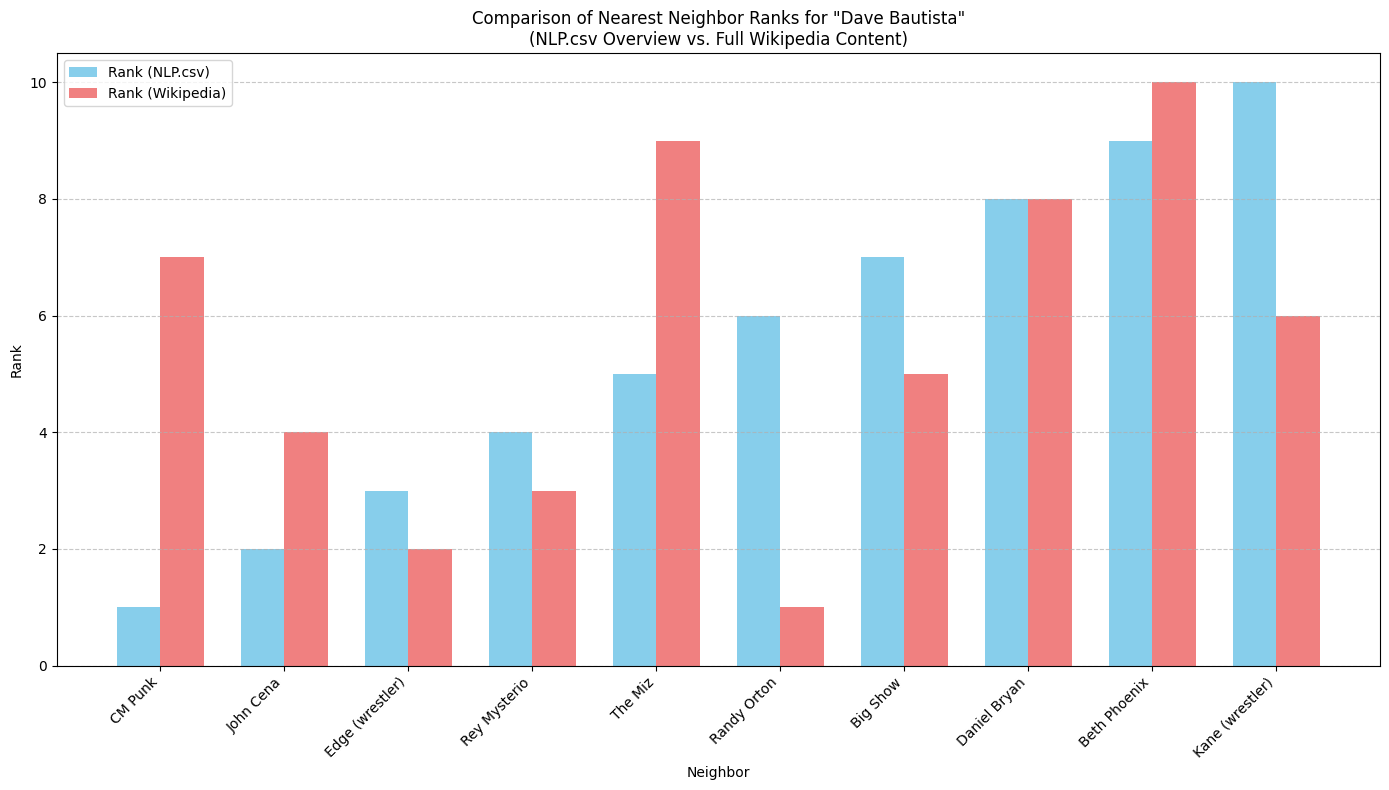

In [76]:
# Merge the two ranking DataFrames on the 'name' column
comparison_df = pd.merge(part1_df, wiki_rank_df, on='name', how='inner')

# Calculate the difference in ranks (positive means NLP.csv rank was numerically higher/worse)
comparison_df['rank_difference'] = comparison_df['rank_nlp_csv'] - comparison_df['rank_wiki']

# Sort the comparison DataFrame by the Part 1 rank for consistent plotting
comparison_df = comparison_df.sort_values(by='rank_nlp_csv').reset_index(drop=True)

print("\nComparison Table (NLP.csv Rank vs. Wikipedia Rank):")
print(comparison_df[['name', 'rank_nlp_csv', 'rank_wiki', 'rank_difference']])

# Plot the comparison
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(comparison_df))

plt.bar(index, comparison_df['rank_nlp_csv'], bar_width, label='Rank (NLP.csv)', color='skyblue')
plt.bar(index + bar_width, comparison_df['rank_wiki'], bar_width, label='Rank (Wikipedia)', color='lightcoral')

plt.xlabel('Neighbor')
plt.ylabel('Rank')
plt.title(f'Comparison of Nearest Neighbor Ranks for "{target_name}"\n(NLP.csv Overview vs. Full Wikipedia Content)')
plt.xticks(index + bar_width / 2, comparison_df['name'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Part 3: Interactive Notebook


Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.


In [98]:
!curl -s https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv | wc -l

42786
